# Tarea 2
## Punto 3
### P-Values
#### Juan Diego Arango y David Bernal

In [1]:
%pylab inline
import numpy as np
import glob
import os
from scipy import stats
from subprocess import check_output
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


El experimento numérico a evaluar en este punto será una marcha aleatoria en 3D.
Para las marchas aleatorias en $d$ dimensiones se tiene que el valor esperado de la distacia $\mathbf{E}(D)$ con respecto al número de pasos dados $N$ (sujeto a que cada paso es de longitud 1) [1] es de
$$\mathbf{E}(D)=\sqrt{\frac{2N}{d}}\frac{\Gamma(\frac{d+1}{2})}{\Gamma(\frac{d}{2})}$$
En donde para el caso de tres dimensiones se tiene
$$\mathbf{E}(D)=2\sqrt{\frac{2N}{3\pi}}$$
Resultados numéricos obtenido de una implementación similar del código en C que se presentará posteriormente de este experimento confirma la predicción teórica con cierta precisión

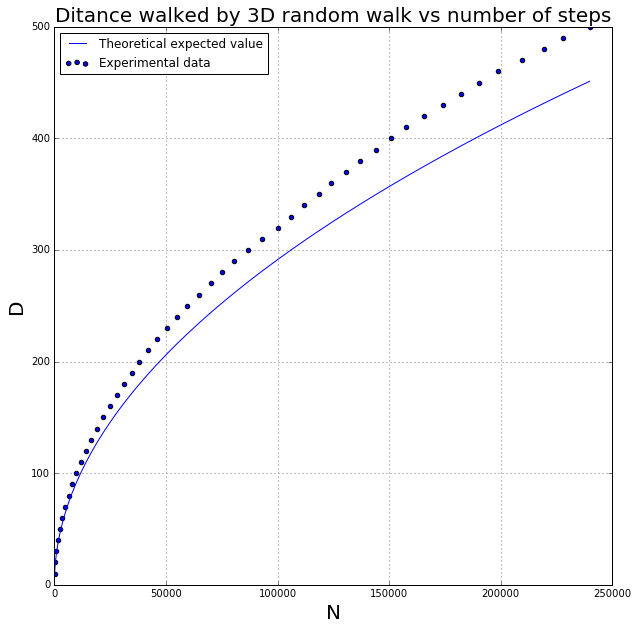

In [2]:
data=np.loadtxt('final_stats_3D_1000.dat')
N_exp=data[:,1]
D_exp=data[:,0]
D_teo=2*sqrt(2*N_exp/(3*pi))
scatter(N_exp,D_exp,label="Experimental data")
plot(N_exp,D_teo,label="Theoretical expected value")
plt.xlabel('N', fontsize=20)
plt.ylabel('D', fontsize=20)
plt.title('Ditance walked by 3D random walk vs number of steps', fontsize=20)
plt.xlim((0,250000))
plt.ylim((0,500))
plt.legend(loc=2)
plt.grid()
#Arreglar gráfica

Con tal de llevar a cabo un análisis de p-value de este experimento numérico se ha escrito un programa en C (3D_randomwalk.c) el cual lleva a cabo marchas aleatorias en 3D iniciadas en cero. Este programa recibe como parámetros el número de pasos a realizar en cada marcha aleatoria y el número de marchas a llevar a cabo. El código compilado retorna el promedio y la desviación estándar de este experimento numérico.

In [3]:
!gcc 3D_randomwalk.c -lm -o 3D_randomwalk.out

In [4]:
!./3D_randomwalk.out

USAGE: ./3D_randomwalk.out Nsteps Nwalks>=2


La prueba estadística a realizar es una prueba t de Student donde la hipótesis nula es que la media de los experimentos corresponda al valor predicho. Se ha elegido arbitrariamente que el valor de pasos tomados por cada marcha aleatoria sea de 500.
$$H_{0}: \overline{X}=\mu=2\sqrt{\frac{2(500)}{3\pi}}\simeq 20.6013$$
Existen 4 suposiciones que debe cumplir un conjunto de datos para que se le pueda llevar a cabo una prueba t de student [2].

$\textbf{1) La variable dependiente debe ser medible en un intervalo o en una razón (ordinal).}$

Para este caso la variable dependiente (que es la distancia recorrida) cumple este criterio.

$\textbf{2) Los datos deben ser independientes (p.e. no correlacionados).}$

Para este caso el código en C está escrito de tal manera que la semilla de los números aleatorios sea el tiempo calendario al momento de ejecutar el código mas un número entero aleatorio. Por lo tanto varía entre experimento y experimento.

$\textbf{3) No debe haber datos atípicos significativos.}$

$\textbf{4) La variable dependiente debe tener una distribución aproximadamente normal.}$


Estas dos últimas suposiciones de van a probar ciertas para nuestros experimentos a partir de un histograma de la distancia para diferentes números de marchas aleatorias (10, 50, 100 y 500) y de la prueba estadística de Shapiro-Wilk[3] y Anderson[4].

La prueba de Shapiro Wilk tiene un estadístico
$$W={\left(\sum_{i=1}^n a_i x_{i}\right)^2 \over \sum_{i=1}^n (x_i-\overline{x})^2}$$
Donde $a_i$ se calcula como
$$(a_1,\dots,a_n) = {m^\top V^{-1} \over (m^\top V^{-1}V^{-1}m)^{1/2}}$$
donde $m$ es
$$m = (m_1,\dots,m_n)^\top$$
Siendo $m_1, ..., m_n$ son los valores medios del estadístico ordenado, de variables aleatorias independientes e identicamente distribuidas, muestreadas de distribuciones normales. $V$ es la matriz de covarianzas de ese estadístico de orden.

Mientras que la de Anderson tiene un estadístico
$$A=\sqrt{-n-\sum_{i=1}^n \frac{2i-1}{n}\left[\ln( \Phi(y_i)) + \ln\left(1-\Phi(y_{n+1-i})\right)\right]}$$
Siento $y_i$ un valor estandarizado y ordenado ${y_1<...<y_n}$ de los datos $x_i$ de forma
$$y_i=\frac{x_i-\mu}{\sigma}$$
Con $\Phi$ siendo la función de probabilidad cumulativa de la distribución a comparar en la hipótesis nula (para el caso de la distribución normal es $\frac{1}{2}[1+erf(\frac{x}{\sqrt{x}})]$ )



Para ambos casos se tiene una hipótesis nula
$$H_{0}: X \sim \mathcal{N}$$

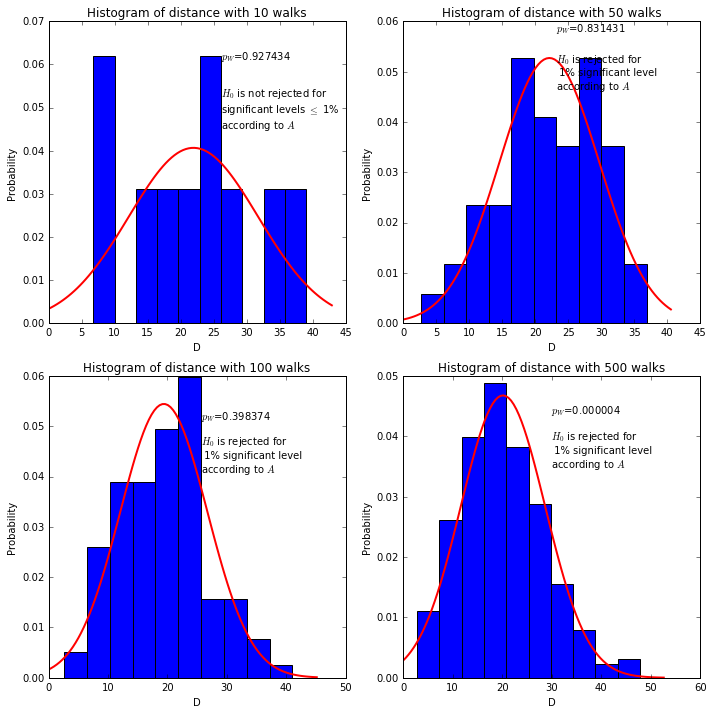

In [7]:
exps=[10,50,100,500]
plt.figure()
k=1
Asig=zeros((4,1))
for exp in exps:
    name=str(exp)+'walks.dat'
    X=np.loadtxt(name)
    subplot(2,2,k)
    x = np.linspace(0, max(X)*1.1, 100)
    n_dist = stats.norm(mean(X),std(X))
    plot(x, n_dist.pdf(x),color='red',linewidth=2)
    histo, bin_edges = np.histogram(X, density=True,bins=10)
    bar(bin_edges[:-1], histo, width=(max(X)-min(X))/10.0)
    xlabel('D')
    ylabel('Probability')
    title(('Histogram of distance with %d walks' %exp))
    [W,pw]=stats.shapiro(X)
    A=stats.anderson(X)
    text(bin_edges[-5],mean(histo)*2,r"$p_W$=%f" % pw,va='center',ha='left')
    for i in range(5):
        if A.critical_values[i]>A.significance_level[i]:
            Asig[k-1]=A.significance_level[i]
    if Asig[k-1]==0:
        text(bin_edges[-5],mean(histo)*1.6,"$H_0$ is not rejected for\n" + "significant levels $\leq$ 1%\n"
             + "according to $A$",va='center',ha='left')
    else:
        text(bin_edges[-5],mean(histo)*1.7,"$H_0$ is rejected for\n" + " %d"% Asig[k-1]+ "% significant level \n" 
             + "according to $A$" ,va='center',ha='left')
        
    k=k+1
    
tight_layout()

Nótese entonces que a menor cantidad de caminatas más diferente es de una distribución normal, de acuerdo a los tests. Para el caso del test de Shapiro-Wilk, el p-value (Oh the Irony!) disminuye con el mayor número de experimentos. De la misma manera de acuerdo con el test de Anderson el nivel de significancia al que se rechaza $H_0$ aumenta con el número de experimentos.

Afortunadamente la distribución de la variable dependiente debe ser APROXIMADAMENTE normal para que la prueba t de Student se pueda aplicar. Con este hecho y teniendo en cuenta que no hay datos atípicos significativos se cumplen todas las suposiciones necesarias para poder aplicar este test.

La prueba t de Student[5] tiene un estadístico para la comparación de la media de una población t igual a 
$$t=\frac{\overline{x}-\mu}{\sigma/\sqrt{n}}$$

Luego se calcula la probabilidad que la muestra de los datos observados no tengan nada que ver con la hipótesis nula, o p-value. Para este caso, dado que es una análisis de las 2 colas de la distribución t (se est{a probando si la media de los datos es diferente y no mayor o menor que la media teórica) se calcula dicha probabilidad como:
$$p=2*(1-\Phi(t))$$

De nuevo siendo $\Phi$ la función cumulativa de probabilidad de una distribución t con $n-1$ grados de libertad. A la función $1-\Phi(t)$ se le conoce como función de supervivencia de t.

Con tal de encontrar la meta-distribución de los p-values se analizarán 1000 conjuntos de diferentes cantidades de experimentos (2, 5, 10, 20, 50, 100, 200, 500 y 1000) de marchas aleatorias con 500 pasos.

In [46]:
Cexps=[2,5,10,20,50,100,200,500,1000]
#Cexps=[10,100,1000]
#Cexps=[10,100]
nruns=1000
p_val=np.zeros((len(Cexps),nruns))
ttest=np.zeros((len(Cexps),nruns))
ttest2=np.zeros((len(Cexps),nruns))
nsteps=500
miu=2*sqrt(2*nsteps/(3*pi))
j=0
for exps in Cexps:
    for i in range(nruns):
        y=check_output(["./3D_randomwalk.out", str(nsteps), str(exps)])
        y=y.split()
        D=float(y[0])
        Desv=float(y[1])
        ttest[j,i] = (D-miu)/(Desv/np.sqrt(float(exps)))  # t-statistic for mean
        
    for i in range(nruns):
        ttest2[j,i] = (ttest[j,i]-mean(ttest[j,:]))/(std(ttest[j,:])/np.sqrt(float(exps)))  # t-statistic for t-value
        p_val[j,i] = 100*(stats.t.sf(np.abs(ttest2[j,i]), exps-1)*2)  # two-sided pvalue = Prob(abs(t)>tt)
    j=j+1

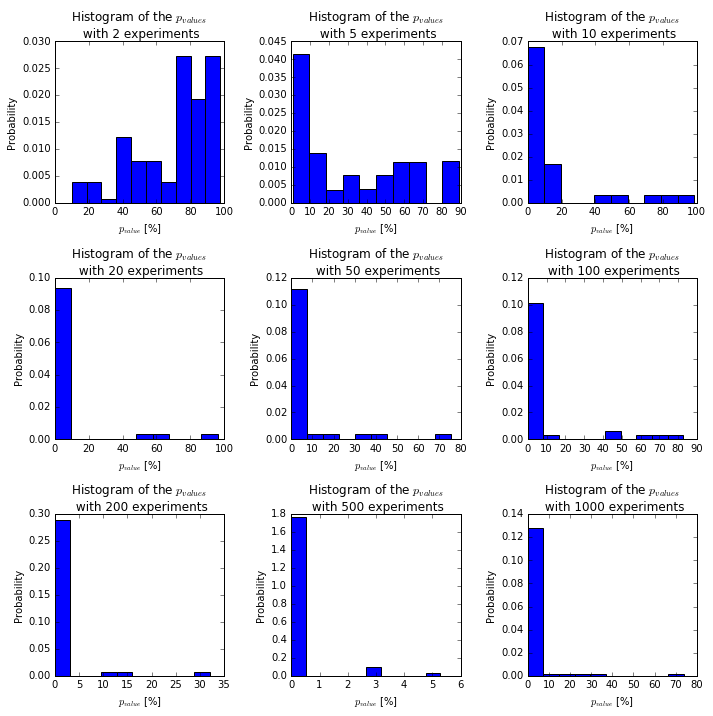

In [47]:
plt.figure()
k=1
p_val_min=np.zeros(len(Cexps))
p_val_max=np.zeros(len(Cexps))
p_val_mean=np.zeros(len(Cexps))
for exps in Cexps:
    subplot(3,3,k)
    histo, bin_edges = np.histogram(p_val[k-1,:], density=True,bins=10)
    p_val_min[k-1]=min(p_val[k-1,:])
    p_val_max[k-1]=max(p_val[k-1,:])
    p_val_mean[k-1]=mean(p_val[k-1,:])
    bar(bin_edges[:-1], histo, width=(p_val_max[k-1]-p_val_min[k-1])/10.0)
    xlabel('$p_{value}$ [%]')
    ylabel('Probability')
    title(('Histogram of the $p_{values}$\n with %d experiments' %exps))
    k=k+1
    
tight_layout()

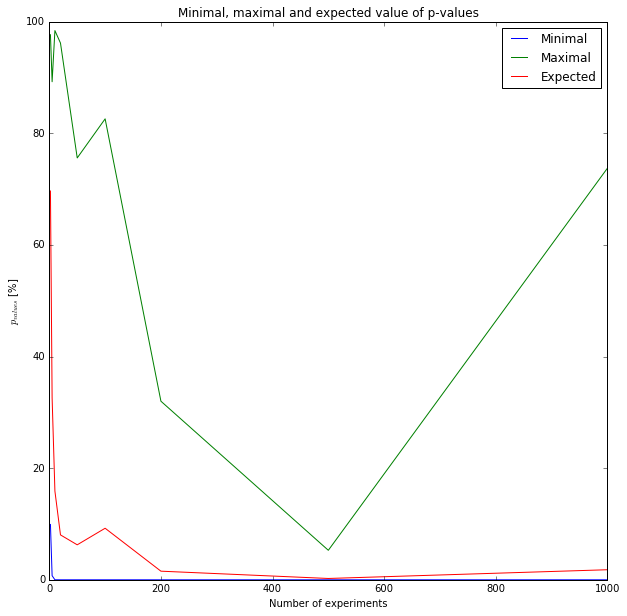

In [48]:
plot(Cexps,p_val_min,label='Minimal')
plot(Cexps,p_val_max,label='Maximal')
plot(Cexps,p_val_mean,label='Expected')
xlabel('Number of experiments')
ylabel('$p_{values}$ [%]')
title('Minimal, maximal and expected value of p-values')
legend(loc=0)

Para repetir el experimento numérico hecho por Taleb en su video, se generó una población de 30 puntos (número de experimentos) 1000 veces. A estos se les llevó a cabo una prueba t Student y a estos estadísticos se les calculío su respectivo p-value.

In [49]:
def ta(size):
    sample=random.normal(0.5, 1.0, size)
    ta=mean(sample)/std(sample)*sqrt(len(sample))
    return ta

In [50]:
def table(amount):
    table1=zeros(amount)
    for i in range(amount):
        table1[i]=ta(30)
    return table1

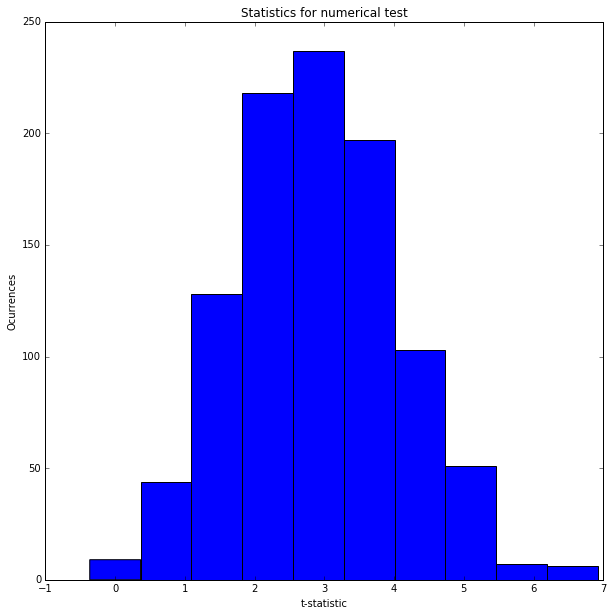

In [51]:
tstudent=table(1000)
mtstudent=mean(tstudent)
h = hist(tstudent)
ylabel('Ocurrences')
xlabel('t-statistic')
title('Statistics for numerical test')

In [52]:
pval=np.zeros((len(tstudent)))
for i in range(len(tstudent)):
    ttest = (tstudent[i]-mtstudent)/(std(tstudent)/np.sqrt(float(30)))  # t-statistic for mean
    pval[i] = stats.t.sf(np.abs(ttest), 30-1)*2  # two-sided pvalue = Prob(abs(t)>tt)

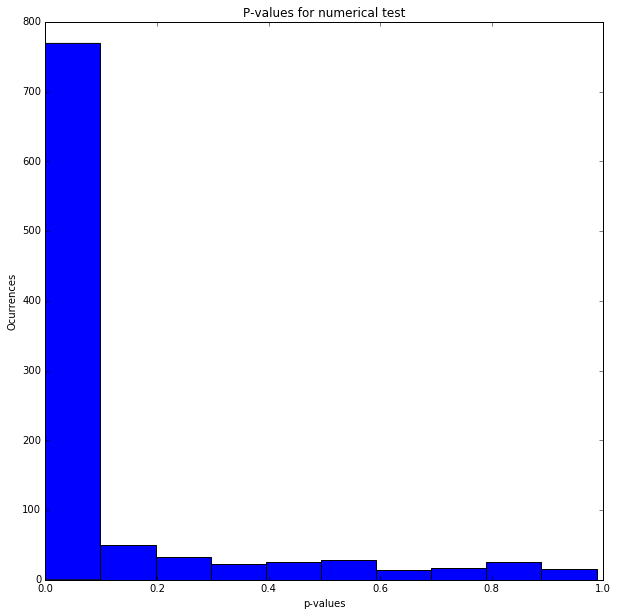

In [53]:
hist(pval)
ylabel('Ocurrences')
xlabel('p-values')
title('P-values for numerical test')

Como se puede notar, en ambos casos se observa una meta-distribución de los p-values, mostrando la validez del artículo de Taleb y dejando mucho que pensar de este afamado método de corroboración de datos estadísticos.

## References

[1] Grinstead, C. M.; Snell, J. L. Introduction to Probability. Chapter 12, Random Walks. Availiable in http://www.dartmouth.edu/~chance/teaching_aids/books_articles/probability_book/Chapter12.pdf

[2] Laerd Statistics. One-Sample T-Test using SPSS Statistics. https://statistics.laerd.com/spss-tutorials/one-sample-t-test-using-spss-statistics.php

[3] Shapiro, S. S.; Wilk, M. B. (1965). «An analysis of variance test for normality (complete samples)». Biometrika 52 (3-4): 591-611. doi:10.1093/biomet/52.3-4.591. JSTOR 2333709 MR 205384

[4] Corder, G.W., Foreman, D.I. (2009). Nonparametric Statistics for Non-Statisticians: A Step-by-Step Approach Wiley, ISBN 978-0-470-45461-9

[5] Fisher Box, Joan (1987). "Guinness, Gosset, Fisher, and Small Samples". Statistical Science 2 (1): 45–52. doi:10.1214/ss/1177013437. JSTOR 2245613.